<center> <h1>PRIMERA PREDICIÓN DEL SUEÑO DE UN PACIENTE</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>

[URL PHYSIONET](https://physionet.org/content/sleep-accel/1.0.0/)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statistics as stats
from sklearn.model_selection import GridSearchCV
from random import sample

In [2]:
pacientes_sueño=[]
for file in (os.listdir("labels")):
    pacientes_sueño.append(os.path.join("labels",file))
    pacientes_sueño=sorted(pacientes_sueño)
    
pacientes_frec_card=[]
for file in os.listdir("heart_rate"):
    pacientes_frec_card.append(os.path.join("heart_rate",file))

pacientes_pasos=[]
for file in os.listdir("steps"):
    pacientes_pasos.append(os.path.join("steps",file))

pacientes_movimiento=[]
for file in os.listdir("motion"):
    pacientes_movimiento.append(os.path.join("motion",file))

La siguiente celda de código se corresponde con la ventana deslizante que recorrerá la señal fisiológica deseada. La función toma como datos de entrada el tamaño de la ventana en segundos y la señal sobre la que se quiere trabajar.

In [3]:
def get_window(w_size,signal,n_sueño):
    time = signal["Tiempo"]
    f_list=[]
    
    for i in range(n_sueño):
        a = w_size*(1+i)
        b = w_size*(2+i)

        idx=[]
        for t in time:
            if t>a and t<b:
                idx.append(True)
            else:
                idx.append(False)
        
        f=signal[idx]
        f_list.append(f)
        
    return f_list

En todos los casos, se seleccionará una w_size de 30 segundos para tener una característica cada 30s y así coincidir la cantidad de los datos adquiridos por medio del Apple Watch con los datos recogidos por la PSG.

Con la señal de frecuencia cardíaca se han decidido sacar 3 vectores de características: mínimo, máximo y media.

### FEATURES

* **feat1: min_list**. La primera característica que se extrae es la lista de frecuencias mínimas.
* **feat2: max_list**. La segunda característica que se extrae es la lista de frecuencias máximas.
* **feat3: mean_list**. La tercera característica que se extrae es la lista de frecuencias medias.

### OUTCOME

* **labels:**. Lista de etiquetas del sueño

### IDENTIFICACION
* **ID:**. Variable que identifica a cada paciente.

# MATRICES HIJAS

Realizamos esta operación sobre todos los pacientes

In [4]:
matrices_hija=[]
for a, (i,j,k,l) in  enumerate(zip(pacientes_sueño,pacientes_frec_card,pacientes_pasos,pacientes_movimiento)):
    #SUEÑO
    sueño=pd.read_csv(i, delimiter=' ')
    sueño.columns=["Tiempo","Etiqueta"]
    s=sueño.replace(to_replace =[-1,5],  value =0) 
    sueño=s.replace(to_replace =[2,3,4],  value =1)    #Etiquetas binarias
    
    #MOVIMIENTO
    #movimiento=pd.read_csv(l, delimiter=' ')
    #movimiento.columns=["Tiempo","Ac_x","Ac_y","Ac_z"]
    #raiz_movto= np.sqrt(movimiento.Ac_x**2 + movimiento.Ac_y**2 + movimiento.Ac_z**2)
    #movimiento['raiz_movto'] = raiz_movto
    #w_size=30
    #signal=movimiento
    #n_sueño=len(sueño)
    #move_list= get_window(w_size,signal,n_sueño)
    
    #mean_mov=[]
    #min_mov=[]
    #max_mov=[]

    #for f in move_list:
     #   mean_mov.append(round(f['raiz_movto'].mean(),2))
      #  min_mov.append(round(f['raiz_movto'].min(),2))
       # max_mov.append(round(f['raiz_movto'].max(),2))
    
    #FRECUENCIA CARDIACA
    frec_card=pd.read_csv(j)
    frec_card.columns=["Tiempo","Frec card"]
    
    w_size=30
    signal=frec_card
    n_sueño=len(sueño)
    f_list= get_window(w_size,signal,n_sueño)

    mean_list=[]
    min_list=[]
    max_list=[]

    for f in f_list:
        mean_list.append(round(f['Frec card'].mean(),2))
        min_list.append(round(f['Frec card'].min(),2))
        max_list.append(round(f['Frec card'].max(),2))
    
    feat1=min_list
    feat2=max_list
    feat3=mean_list
    #feat4=min_mov
    #feat5=max_mov
    #feat6=mean_mov
    labels=sueño["Etiqueta"]
    id_list=[a]*len(labels)
    #'Min_mvto': feat4, "Max_mvto": feat5,"Mean_mvto":feat6
    datos = {'Min_hr': feat1, "Max_hr": feat2,"Mean_hr":feat3,"Etiquetas":labels,"ID_P":id_list}
    datos_paciente = pd.DataFrame(data=datos)
    matrices_hija.append(datos_paciente) #matrices_hija=matriz_madre, están todas las hijas en esta variable

In [5]:
#matrices_hija[14].describe()

En la variable matrices_hija tenemos las matrices de características de cada paciente. Es decir, matrices_hija es la matriz_madre.

Esto es una funcion para limpiar el dataframe de Nan y valores inf en caso de que fuera necesario.

In [6]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

#### PARTICIÓN TRAIN Y TEST

In [28]:
lista=list(range(31))
train=sample(lista,k=20)      #aletoriedad y porcentaje de TRAIN y test
test = [ele for ele in lista if ele not in train]

#Vale aqui tengo los numero que quiero pero no se como ponerlo en matrices hija sin qeu coja [], solo quiero los valores

#TRAIN
Training=pd.concat(matrices_hija[0:22])   #cambiar esto
Training= clean_dataset(Training) # Tratar los Nan porque da errores en el calsificador
Train=Training.drop('Etiquetas',axis=1) 

X_train=Train.drop('ID_P',axis=1)
y_train=Training["Etiquetas"]

#TEST
Test=pd.concat(matrices_hija[23:])  #change 
Test=clean_dataset(Test)            # Tratar los Nan porque da errores en el calsificador
Test_f=Test.drop('Etiquetas',axis=1)
X_test=Test_f.drop('ID_P',axis=1)
y_test=Test["Etiquetas"]


In [29]:
X_train

,Min_hr,Max_hr,Mean_hr
0,49.0,54.0,50.83
1,50.0,54.0,52.40
2,53.0,54.0,53.83
3,56.0,68.0,60.50
4,51.0,52.0,51.67
...,...,...,...
959,71.0,78.0,74.33
960,65.0,72.0,69.00
961,66.0,71.0,68.00
962,70.0,78.0,74.50


In [30]:
X_test

,Min_hr,Max_hr,Mean_hr
0,59.0,59.0,59.00
1,59.0,61.0,59.67
2,59.0,64.0,60.83
3,59.0,60.0,59.17
4,59.0,59.0,59.00
...,...,...,...
714,68.0,78.0,70.17
715,69.0,69.0,69.00
716,65.0,68.0,65.60
717,68.0,71.0,70.17


# SOBRE CONJUNTO TOTAL

#### 1. SELECCIÓN MODELO

In [31]:
# SOBRE CONJUNTO TOTAL
clf = SVC()

#### 2.SELECCIÓN MEJORES PARÁMETROS LIBRES

In [32]:
parameters = {'kernel':('linear', 'rbf'), 'C':list(range(1,10))}
svc_clf=GridSearchCV(clf, parameters, scoring='accuracy',n_jobs=-1)
svc_clf.fit(X_train, y_train) 
svc_clf.best_params_
svc_clf.best_estimator_

C:\Users\rober\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### 3.EVALUACIÓN DEL MODELO

In [33]:
predict = svc_clf.predict(X_test)
#EVALUACION

acc_test= svc_clf.score(X_test, y_test).round(4)
acc_train= svc_clf.score(X_train, y_train).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print('Confusion Matrix')
print(confusion_matrix(y_test, predict),'\n')
#print("=============== Classification Report ================")
#print(classification_report(y_test, predict))

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.677 

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.6929 

Confusion Matrix
[[ 150 2280]
 [ 126 4892]] 



In [34]:
matriz_confusion=pd.crosstab(y_test,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

In [35]:
matriz_confusion

Resultado del clasificador,0.0,1.0
Clase predicha,,
0.0,150,2280
1.0,126,4892


#### 4. GRÁFICAS RESIDUOS

No handles with labels found to put in legend.


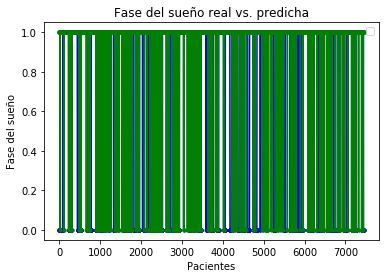

In [37]:
pacientes = len(y_test)
t = np.arange(0,pacientes)
plt.figure()
plt.plot(t,y_test,color='blue', marker='.')
plt.plot(t,predict,color='green', marker='.')
plt.xlabel('Pacientes')
plt.ylabel('Fase del sueño')
plt.title('Fase del sueño real vs. predicha')
plt.legend()

# MODELO PARA PRIMERA VENTANA

Para construir un clasificador SVM, al meter todas las ventanas de todos los pacientes tenemos una salida multiclase, (y esto no nos lo predice bien, predice una salida biclase). 

Por ello, a continuación vamos a concatenar la primera ventana de cada paciente. Las primeras ventanas (30s) del 70% de los pacientes las utilizaremos para entrenar un clasificador SVM y vamos a predecir las primeras ventanas del 30% de los pacientes. 



In [38]:
# Quiero concatenar los primeros 30s de todos los pacientes
primera_ventana=pd.DataFrame()
for i in range(len(matrices_hija)):
    ven1=matrices_hija[i].iloc[0,:]
    primera_ventana=primera_ventana.append(ven1)


In [39]:
#primera_ventana

In [40]:
# Train y Test. Train: 70%, Test: 30%
train, test = train_test_split(primera_ventana, test_size = 0.30)
#train, val = train_test_split(train, test_size = 0.30)

In [41]:
#train

In [42]:
#TRAIN
#Training= clean_dataset(train) 
X_train=train.iloc[:,2:5]
y_train=train["Etiquetas"]

#TEST
#Test=clean_dataset(Test)            
X_test=test.iloc[:,2:5]
y_test=test["Etiquetas"]

In [52]:
y_train

0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
0    0.0
Name: Etiquetas, dtype: float64

#### Creación modelo, selección parámetros libres y evaluación

In [47]:
#CREACION #decision_function_shape='ovo'
clf = SVC().fit(X_train,y_train)

ValueError: The number of classes has to be greater than one; got 1 class

In [48]:

predict = clf.predict(X_test)
#EVALUACION

acc_test= clf.score(X_test, y_test).round(4)
acc_train= sclf.score(X_train, y_train).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print('Confusion Matrix')
print(confusion_matrix(y_test, predict),'\n')
#print("=============== Classification Report ================")
#print(classification_report(y_test, predict))

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [49]:
matriz_confusion=pd.crosstab(y_test,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

ValueError: could not broadcast input array from shape (7448) into shape (10)

In [50]:
matriz_confusion

Resultado del clasificador,0.0,1.0
Clase predicha,,
0.0,150,2280
1.0,126,4892


# Residuos

In [ ]:
#y_test

In [ ]:
#predict

In [ ]:
pacientes = len(y_test)
t = np.arange(0,pacientes)
plt.figure()
plt.plot(t,y_test,color='blue', marker='.',label='Real')
plt.plot(t,predict,color='green', marker='.',label='Predicha')
plt.xlabel('Pacientes')
plt.ylabel('Fase del sueño')
plt.title('Fase del sueño real vs. predicha en los primeros 30s')
plt.legend()

In [ ]:
residuo=predict-y_test
plt.figure()
plt.plot(t,residuo,marker='.')
plt.xlabel('Pacientes')
plt.ylabel('Residuo')
plt.title('Residuo primera ventana')
